In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from RNN_utils import *
from RNN_Model import RnnModel, train_rnn_model

import warnings
warnings.filterwarnings("ignore")

daily = pd.read_csv('../../../Dataset/Boulder_Daily.csv')
daily.drop(columns={'Unnamed: 0'}, inplace=True)
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1668 entries, 0 to 1667
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Energy__kWh_   1668 non-null   float64
 1   Weekday        1668 non-null   object 
 2   Month          1668 non-null   object 
 3   Minimum T      1668 non-null   int64  
 4   Maximum T      1668 non-null   int64  
 5   Snow           1668 non-null   float64
 6   Precipitation  1668 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 91.3+ KB


## **Preprocessing**

    Divided the dataset into training, testing, and validation datasets according to 0.70, 0.20, and 0.10, respectively.

In [20]:
train_daily, val_daily, test_daily = split_dataset(daily, train_ratio=0.7, val_ratio=0.2)

Training split ratio:   0.7
Validation split ratio: 0.2
Testing split ratio:    0.101

Shapes of the datasets:
(1167, 7) (333, 7) (168, 7)


    One Hot Encode

In [21]:
train_daily

,Energy__kWh_,Weekday,Month,Minimum T,Maximum T,Snow,Precipitation
0,6.504,Monday,January,12,30,0.0000,0.00000
1,17.527,Tuesday,January,24,92,0.0000,0.00000
2,11.227,Wednesday,January,60,150,0.0000,0.00000
3,49.748,Thursday,January,144,312,0.0000,0.00000
4,2.956,Friday,January,50,124,0.0000,0.00000
...,...,...,...,...,...,...,...
1162,46.784,Friday,March,288,378,88490.1456,19172.86488
1163,25.689,Saturday,March,116,160,157315.8144,24908.33728
1164,15.282,Monday,March,68,160,52438.6048,3932.89536
1165,125.330,Tuesday,March,189,360,0.0000,0.00000


In [22]:
# List of all months and weekdays
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# One-hot encode 'Month' and 'Weekday' columns for train_daily and drop 'Month' and 'Weekday' columns after one-hot encoding
train_daily = one_hot_encode(train_daily, months, weekdays)
train_daily.drop(columns=['Month', 'Weekday'], inplace=True)

# One-hot encode 'Month' and 'Weekday' columns for val_daily and drop 'Month' and 'Weekday' columns after one-hot encoding
val_daily = one_hot_encode(val_daily, months, weekdays)
val_daily.drop(columns=['Month', 'Weekday'], inplace=True)

# One-hot encode 'Month' and 'Weekday' columns for test_daily and drop 'Month' and 'Weekday' columns after one-hot encoding
test_daily = one_hot_encode(test_daily, months, weekdays)
test_daily.drop(columns=['Month', 'Weekday'], inplace=True)

In [23]:
train_daily.head(15)

,Energy__kWh_,Minimum T,Maximum T,Snow,Precipitation,January,February,March,April,May,...,October,November,December,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,6.504,12,30,0.0000,0.00000,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,17.527,24,92,0.0000,0.00000,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,11.227,60,150,0.0000,0.00000,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,49.748,144,312,0.0000,0.00000,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2.956,50,124,0.0000,0.00000,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,32.720,180,360,0.0000,0.00000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,30.612,120,220,0.0000,0.00000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,24.460,50,112,0.0000,0.00000,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,45.802,216,402,0.0000,0.00000,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,47.038,352,472,0.0000,1310.96512,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


    Create sequences for the RNNs model

In [24]:
# Define the time window size
sequence_length = 140

# Create sequences for training data
X_train, Y_train = create_sequences(train_daily, sequence_length, 'Energy__kWh_', step=1)
# Create sequences for validation data
X_val, Y_val = create_sequences(val_daily, sequence_length, 'Energy__kWh_', step=1)
# Create sequences for test data
X_test, Y_test = create_sequences(test_daily, sequence_length, 'Energy__kWh_', step=1)

Dataset split into sequences:
Sequences shape: (1027, 140, 24)
Targets shape: (1027,)

Dataset split into sequences:
Sequences shape: (193, 140, 24)
Targets shape: (193,)

Dataset split into sequences:
Sequences shape: (28, 140, 24)
Targets shape: (28,)



**Scalling the Numerical columns**

    Scaling the X_train and Y_train

In [25]:
# We scale also with MinMaxScaler this columns ['Energy__kWh_', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow']
numerical_D = len(['Energy__kWh_', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow'])

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# ----------------------
#    SCALE THE X_train
# ----------------------

# Extract the first 5 columns from X_train
X_train_subset = X_train[:, :, :numerical_D]

# Reshape the subset to 2D array
X_train_subset_2d = X_train_subset.reshape(-1, numerical_D)

# Fit the scaler on the subset and transform it
x_scaler = scaler.fit_transform(X_train_subset_2d)

# Reshape the scaled subset back to the original shape
X_train_scaled_subset = x_scaler.reshape(X_train.shape[0], X_train.shape[1], numerical_D)

# Combine the scaled subset with the remaining columns of X_train
X_train_scaled = np.concatenate([X_train_scaled_subset, X_train[:, :, 5:]], axis=-1)


# ----------------------
#    SCALE THE Y_train
# ----------------------

# Reshape the subset to 2D array
Y_train_reshaped = Y_train.reshape(-1,1)

# Add extra columns of zeros to match the expected dimension for concatenation
Y_train_reshaped = np.concatenate((Y_train_reshaped, np.zeros((Y_train_reshaped.shape[0], numerical_D-1))), axis=1)

# Use the previously fitted scaler to transform the Y_train_reshaped
Y_train_scaled = scaler.transform(Y_train_reshaped)

# Keep only the energy column (target) in the Y_train_scaled
Y_train_scaled = Y_train_scaled[:,:1]

    Scaling the X_val, X_test and Y_val, Y_test accord to X_train MinMaxScaler

In [26]:
X_val_scaled, Y_val_scaled = scale_data_with_fitted_scaler(scaler, X_val, Y_val, numerical_D)
X_test_scaled, Y_test_scaled = scale_data_with_fitted_scaler(scaler, X_test, Y_test, numerical_D)

print('Train Dataset:')
print("scaled X_train shape:", X_train_scaled.shape)
print("scaled Y_train shape:", Y_train_scaled.shape)

print('\nValidation Dataset:')
print("scaled X_val shape:", X_val_scaled.shape)
print("scaled Y_val shape:", Y_val_scaled.shape)

print('\nTest Dataset:')
print("scaled X_test shape:", X_test_scaled.shape)
print("scaled Y_test shape:", Y_test_scaled.shape)

Train Dataset:
scaled X_train shape: (1027, 140, 24)
scaled Y_train shape: (1027, 1)

Validation Dataset:
scaled X_val shape: (193, 140, 24)
scaled Y_val shape: (193, 1)

Test Dataset:
scaled X_test shape: (28, 140, 24)
scaled Y_test shape: (28, 1)


    Create the RNNs Models

In [27]:
# Define the input shape for the models ||  input_shape = (sequence_length, num_features)
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])

# Create LSTM model
# Define the default regularation l2=0.01  ||  If we want we can train the model without regularations. (regularization = 0)
lstm = RnnModel('LSTM', input_shape, num_layers=6, num_units=128, regularization=0.01)

# Create Simple RNN model
simple_rnn = RnnModel('SimpleRNN', input_shape, num_layers=3, num_units=64, regularization=0.01)

# Create Bi-LSTM model
bi_lstm = RnnModel('Bi-LSTM', input_shape, num_layers=3, num_units=64, regularization=0.01)

# Create GRU model
gru = RnnModel('GRU', input_shape, num_layers=3, num_units=64, regularization=0.01)

In [28]:
# Print summaries of the configurations
print("LSTM Summary:")
lstm.summary()
print()

print("Simple RNN Summary:")
simple_rnn.summary()
print()

print("Bi-LSTM Summary:")
bi_lstm.summary()
print()

print("GRU Summary:")
gru.summary()

LSTM Summary:
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 140, 128)          78336     
                                                                 
 lstm_10 (LSTM)              (None, 140, 128)          131584    
                                                                 
 lstm_11 (LSTM)              (None, 140, 128)          131584    
                                                                 
 lstm_12 (LSTM)              (None, 140, 128)          131584    
                                                                 
 lstm_13 (LSTM)              (None, 140, 128)          131584    
                                                                 
 lstm_14 (LSTM)              (None, 128)               131584    
                                                                 
 dense_4 (Dense)             (None, 1)  

    Compile the Models

In [29]:
# Define the learning rate for Adam optimizer
learning_rate = 0.001

# Compile each RNN model
lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae', 'mse', root_mean_squared_error])

simple_rnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae', 'mse', root_mean_squared_error])

bi_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae', 'mse', root_mean_squared_error])

gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse', metrics=['mae', 'mse', root_mean_squared_error])

    Train the Models

In [30]:
# Define the parameters for training
lstm_epochs = 100
simple_rnn_epochs, bi_lstm_epochs, gru_epochs = 200, 200, 200
batch_size = 1

# Train each RNN model
print('-----------------\nLSTM Training\n-----------------\n')
lstm_history = train_rnn_model(lstm, X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, lstm_epochs, batch_size)

print('\n-----------------\nSimpleRNN / Vanilla RNN Training\n-----------------\n')
simple_rnn_history = train_rnn_model(simple_rnn, X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, simple_rnn_epochs, batch_size)

print('\n-----------------\nBi-LSTM Training\n-----------------\n')
bi_lstm_history = train_rnn_model(bi_lstm, X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, bi_lstm_epochs, batch_size)

print('\n-----------------\nGRU Training\n-----------------\n')
gru_history = train_rnn_model(gru, X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, gru_epochs, batch_size)

-----------------
LSTM Training
-----------------

Epoch 1/100
1027/1027 [==============================] - 340s 319ms/step - loss: 3.5579 - mae: 0.1533 - mse: 0.0360 - root_mean_squared_error: 0.1533 - val_loss: 0.6070 - val_mae: 0.3367 - val_mse: 0.1360 - val_root_mean_squared_error: 0.3367
Epoch 2/100
1027/1027 [==============================] - 394s 383ms/step - loss: 0.1429 - mae: 0.1475 - mse: 0.0334 - root_mean_squared_error: 0.1475 - val_loss: 0.1552 - val_mae: 0.3581 - val_mse: 0.1515 - val_root_mean_squared_error: 0.3581
Epoch 3/100
1027/1027 [==============================] - 440s 429ms/step - loss: 0.0340 - mae: 0.1478 - mse: 0.0327 - root_mean_squared_error: 0.1478 - val_loss: 0.1341 - val_mae: 0.3330 - val_mse: 0.1335 - val_root_mean_squared_error: 0.3330
Epoch 4/100
1027/1027 [==============================] - 336s 326ms/step - loss: 0.0336 - mae: 0.1472 - mse: 0.0327 - root_mean_squared_error: 0.1472 - val_loss: 0.1046 - val_mae: 0.2873 - val_mse: 0.1039 - val_root_mean

    Evaluate the Models

In [31]:
def evaluate_model(model, model_name, X_train, Y_train, X_val, Y_val, X_test, Y_test):
    train_eval = model.evaluate(X_train, Y_train, verbose=0)
    val_eval = model.evaluate(X_val, Y_val, verbose=0)
    test_eval = model.evaluate(X_test, Y_test, verbose=0)

    print(f'\nEvaluation metrics for {model_name} model:\n-------------------')
    print('Training Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}\n'.format(train_eval[0], train_eval[3], train_eval[1], train_eval[2]))
    print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}\n'.format(val_eval[0], val_eval[3], val_eval[1], val_eval[2]))
    print('Test Data - Loss: {:.4f}, MAE: {:.4f}, RMSE: {:.4f}, MSE: {:.4f}'.format(test_eval[0], test_eval[3], test_eval[1], test_eval[2]),'\n')

evaluate_model(lstm, 'LSTM',X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test_scaled, Y_test_scaled)
evaluate_model(simple_rnn, 'RNN',X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test_scaled, Y_test_scaled)
evaluate_model(bi_lstm, 'Bi-LSTM',X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test_scaled, Y_test_scaled)
evaluate_model(gru, 'GRU',X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test_scaled, Y_test_scaled)


Evaluation metrics for LSTM model:
-------------------
Training Data - Loss: 0.0321, MAE: 0.1735, RMSE: 0.1475, MSE: 0.0321

Validation Data - Loss: 0.1110, MAE: 0.3037, RMSE: 0.2988, MSE: 0.1110

Test Data - Loss: 0.4614, MAE: 0.6792, RMSE: 0.6525, MSE: 0.4614 


Evaluation metrics for RNN model:
-------------------
Training Data - Loss: 0.0219, MAE: 0.1211, RMSE: 0.0973, MSE: 0.0161

Validation Data - Loss: 0.0447, MAE: 0.1809, RMSE: 0.1576, MSE: 0.0389

Test Data - Loss: 0.0863, MAE: 0.2839, RMSE: 0.2318, MSE: 0.0806 


Evaluation metrics for Bi-LSTM model:
-------------------
Training Data - Loss: 0.0321, MAE: 0.1738, RMSE: 0.1478, MSE: 0.0321

Validation Data - Loss: 0.1091, MAE: 0.3007, RMSE: 0.2957, MSE: 0.1091

Test Data - Loss: 0.4571, MAE: 0.6761, RMSE: 0.6492, MSE: 0.4571 


Evaluation metrics for GRU model:
-------------------
Training Data - Loss: 0.0227, MAE: 0.1229, RMSE: 0.0983, MSE: 0.0175

Validation Data - Loss: 0.0468, MAE: 0.1767, RMSE: 0.1632, MSE: 0.0416

Test D

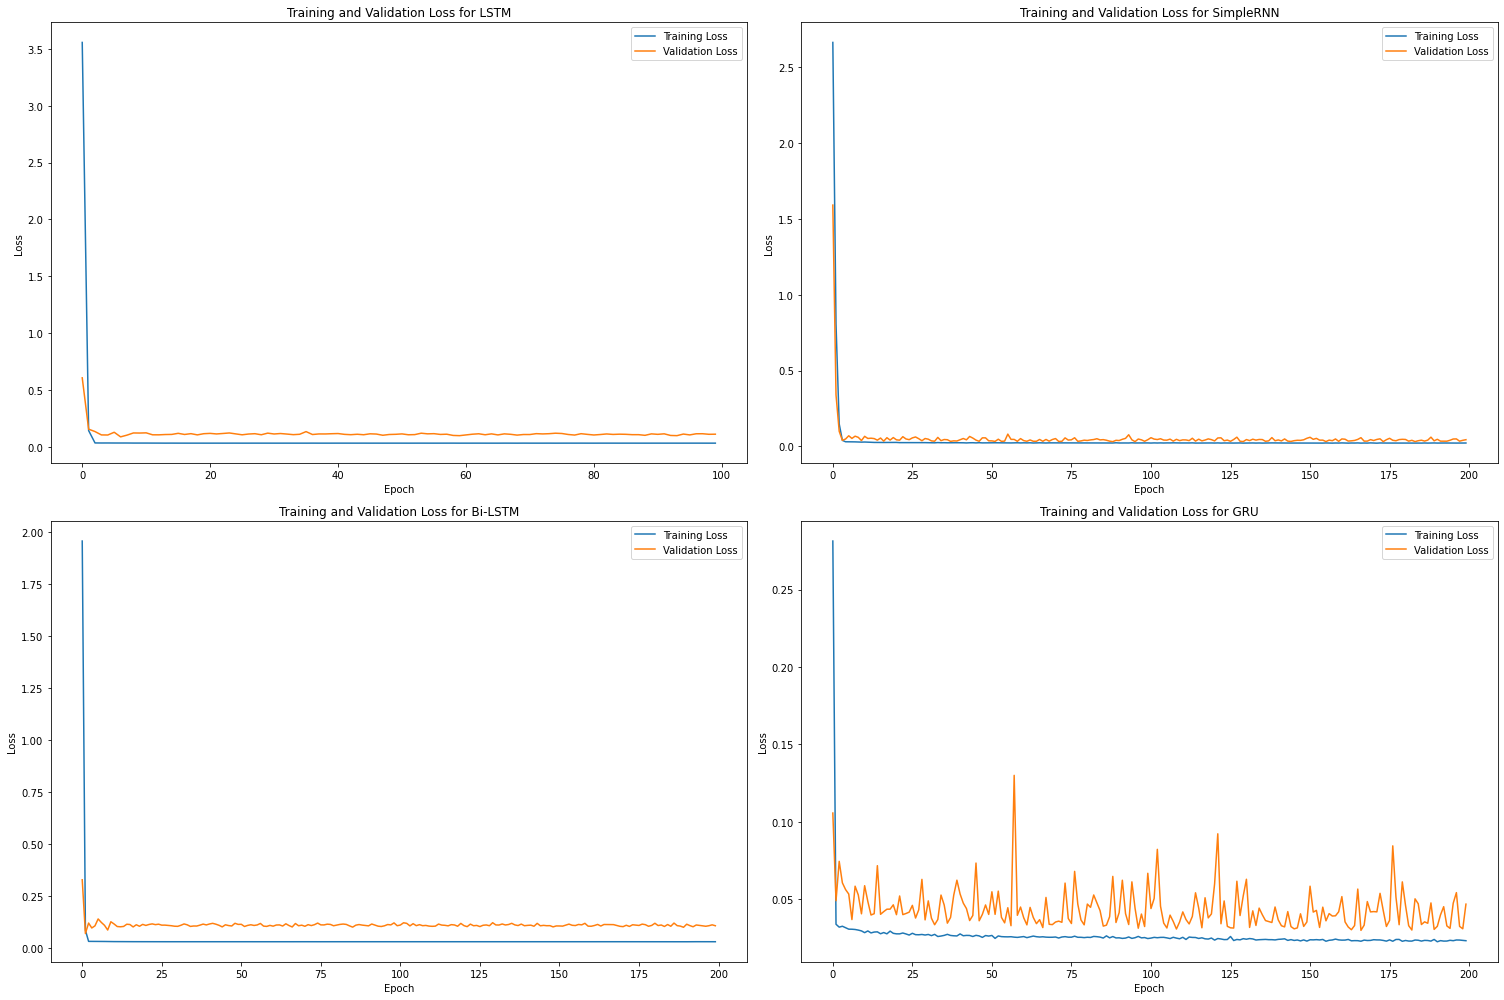

In [32]:
def plot_loss(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss for ' + model_name)
    ax.legend()


fig, axes = plt.subplots(2, 2, figsize=(21, 14))
axes = axes.flatten()

histories = []
model_names = ['LSTM', 'SimpleRNN', 'Bi-LSTM', 'GRU']
histories.extend([lstm_history, simple_rnn_history, bi_lstm_history, gru_history])

for i, (history, model_name) in enumerate(zip(histories, model_names)):
    plot_loss(history, model_name, axes[i])

# Hide empty subplots
for i in range(len(histories), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

    Make predictions with Train, Validation and Test Dataset and evaluate them with MAE and RMSE

In [33]:
evaluate_predictions_model(lstm, 'LSTM', X_train_scaled, Y_train, X_val_scaled, Y_val, X_test_scaled, Y_test, scaler)
evaluate_predictions_model(simple_rnn, 'RNN', X_train_scaled, Y_train, X_val_scaled, Y_val, X_test_scaled, Y_test, scaler)
evaluate_predictions_model(bi_lstm, 'Bi-LSTM', X_train_scaled, Y_train, X_val_scaled, Y_val, X_test_scaled, Y_test, scaler)
evaluate_predictions_model(gru, 'GRU', X_train_scaled, Y_train, X_val_scaled, Y_val, X_test_scaled, Y_test, scaler)

1/1 [==============================] - 2s 2s/step


Evaluation metrics for LSTM model:
-------------------
Train Dataset:
RMSE: 90.71144057405988
MAE: 74.72998612265137
-------------------
Validation Dataset:
RMSE: 168.78149650756998
Validation MAE: 151.39037720876902
-------------------
Test Dataset:
Test RMSE: 344.12072355395117
Test MAE: 330.5779932545253


1/1 [==============================] - 0s 81ms/step


Evaluation metrics for RNN model:
-------------------
Train Dataset:
RMSE: 64.30169838449805
MAE: 49.2998077981609
-------------------
Validation Dataset:
RMSE: 99.95334031467848
Validation MAE: 79.82454068050484
-------------------
Test Dataset:
Test RMSE: 143.825957617409
Test MAE: 117.42313650621688


1/1 [==============================] - 1s 556ms/step


Evaluation metrics for Bi-LSTM model:
-------------------
Train Dataset:
RMSE: 90.73443978507146
MAE: 74.89533400463338
-------------------
Validation Dataset:
RMSE: 167.3201636269034
Validation MAE: 149.81813664399775
---